In [709]:
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
from typing import Tuple
from sklearn.metrics import confusion_matrix, auc
import seaborn as sns

np.random.seed(1111)

In [710]:
class Metrics:
    @staticmethod
    def k_fold_cross_validation(x, y, k: int, x_column_names: list = None, y_column_names: list = None, folds_to_return: int = None):
        if k <= 0 or k > len(x):
            raise ValueError(
                "k must be greater than 0 and less than the number of rows in the dataset")

        if len(x) != len(y):
            raise ValueError(
                "The number of rows in the dataset must be equal to the number of rows in the expected output")

        if folds_to_return is None:
            folds_to_return = k

        # Shuffle the dataset
        shuffled_dataset = list(zip(x, y))
        np.random.shuffle(shuffled_dataset)
        x, y = map(
            np.array, zip(*shuffled_dataset))

        fold_len = int(len(x) / k)
        folds = []

        # Split the dataset into k folds
        # Maybe we want less folds than k
        for i in range(min(k, folds_to_return)):
            x_test = x[i *
                       fold_len: (i + 1) * fold_len]
            y_test = y[i *
                       fold_len: (i + 1) * fold_len]

            x_train = np.concatenate(
                [x[:i * fold_len],
                 x[(i + 1) * fold_len:]])

            y_train = np.concatenate(
                [y[:i * fold_len],
                 y[(i + 1) * fold_len:]])

            # If df_columns is not None, then we need to create a dataframe for both sets
            if x_column_names is not None:
                x_train = pd.DataFrame(
                    x_train, columns=x_column_names)
                x_test = pd.DataFrame(
                    x_test, columns=x_column_names)
                y_train = pd.DataFrame(
                    y_train, columns=y_column_names)
                y_test = pd.DataFrame(
                    y_test, columns=y_column_names)

            # Load the test and train sets into the folds
            folds.append({
                'x_train': x_train,
                'y_train': y_train,
                'x_test': x_test,
                'y_test': y_test,
            })

        return folds

    @staticmethod
    def k_fold_cross_validation_eval(x, y, model, k: int, x_column_names: list = None, y_column_names: list = None):
        if model is None:
            raise ValueError("Model cannot be None")

        folds = Metrics.k_fold_cross_validation(
            x, y, k=k, x_column_names=x_column_names, y_column_names=y_column_names)

        # Evaluate the model on each fold
        results = []
        errors = []
        k_metrics_per_class = {
            'accuracy': {label: [] for label in model.classes},
            'precision': {label: [] for label in model.classes},
            'recall': {label: [] for label in model.classes},
            'f1-score': {label: [] for label in model.classes},
            'tp-rate': {label: [] for label in model.classes},
            'fp-rate': {label: [] for label in model.classes},
        }

        for fold in folds:
            # Train the model
            x_train = fold['x_train']
            y_train = fold['y_train']
            model.train(pd.concat([x_train, y_train], axis=1))

            # Evaluate the model on the test set
            x_test = fold['x_test']
            y_test = fold['y_test']
            predictions = model.test(pd.concat([x_test, y_test], axis=1))

            # Compute the metrics
            cf_matrix = Metrics.get_confusion_matrix(
                predictions[model.classes_column_name].values.tolist(), predictions[model.predicted_class_column_name].values.tolist(), labels=model.classes)
            
            metrics_df = Metrics.get_metrics_per_class(cf_matrix)[1]

            # Push the metrics to the total metrics
            for metric_label in k_metrics_per_class:
                for label in model.classes:
                    k_metrics_per_class[metric_label][label].append(metrics_df[metric_label][label])

            results.append(predictions)
            errors.append(Metrics.error(predictions, y_test,
                          uses_df=x_column_names is not None))

        # Compute the average and standard deviation metrics
        average_metrics = {metric_label: {label: np.mean(k_metrics_per_class[metric_label][label]) for label in model.classes} for metric_label in k_metrics_per_class}
        std_metrics = {metric_label: {label: np.std(k_metrics_per_class[metric_label][label]) for label in model.classes} for metric_label in k_metrics_per_class}
                

        return results, errors, k_metrics_per_class, average_metrics, std_metrics

    @staticmethod
    def error(predictions, y, uses_df=False):
        if uses_df:
            predictions = predictions.values
            y = y.values

        return functools.reduce(
            lambda x, y: 0 if x == y else 1, list(zip(predictions, y)), 0) / len(predictions)

    @staticmethod
    def get_confusion_matrix(y, y_pred, labels=None) -> pd.DataFrame:
        cf_matrix = confusion_matrix(y, y_pred, labels=labels)
        return pd.DataFrame(cf_matrix, index=labels, columns=labels)

    @staticmethod
    def plot_confusion_matrix_heatmap(cf_matrix, predicted_title="Predicted label", actual_title="Truth label", plot_title=""):
        ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='d')
        ax.set_xlabel(predicted_title, fontsize=15)
        ax.set_ylabel(actual_title, fontsize=15)
        plt.yticks(rotation=0)
        ax.xaxis.tick_top()  # x axis on top
        ax.xaxis.set_label_position('top')
        plt.rcParams["figure.figsize"] = (8, 6)
        plt.title(plot_title, fontsize=20)
        plt.show()

    # https://arxiv.org/pdf/2008.05756#:~:text=Accuracy%20is%20one%20of%20the,computed%20from%20the%20confusion%20matrix.&text=The%20formula%20of%20the%20Accuracy,confusion%20matrix%20at%20the%20denominator.
    @staticmethod
    def get_tp_for_class(cf_matrix, label):
        return cf_matrix[label][label]

    @staticmethod
    def get_tn_for_class(cf_matrix, label):
        # Sum all values and subtract other metrics
        return cf_matrix.to_numpy().sum() - \
            (Metrics.get_tp_for_class(cf_matrix, label) +
             Metrics.get_fp_for_class(cf_matrix, label) +
             Metrics.get_fn_for_class(cf_matrix, label))

    @staticmethod
    def get_fp_for_class(cf_matrix, label):
        # Sum all rows except the label row
        return sum(cf_matrix.loc[:, label]) - cf_matrix[label][label]

    @staticmethod
    def get_fn_for_class(cf_matrix, label):
        # Sum all columns except the label column
        return sum(cf_matrix.loc[label, :]) - cf_matrix[label][label]

    @staticmethod
    def get_accuracy_for_class(cf_matrix, label):
        # (TP + TN) / (TP + TN + FP + FN)
        numerator = Metrics.get_tp_for_class(
            cf_matrix, label) + Metrics.get_tn_for_class(cf_matrix, label)
        denominator = numerator + \
            Metrics.get_fp_for_class(cf_matrix, label) + \
            Metrics.get_fn_for_class(cf_matrix, label)
        return numerator / denominator

    @staticmethod
    def get_precision_for_class(cf_matrix, label):
        # TP / (TP + FP)
        numerator = Metrics.get_tp_for_class(cf_matrix, label)
        denominator = numerator + Metrics.get_fp_for_class(cf_matrix, label)
        return numerator / denominator

    @staticmethod
    def get_recall_for_class(cf_matrix, label):
        # TP / (TP + FN)
        numerator = Metrics.get_tp_for_class(cf_matrix, label)
        denominator = numerator + Metrics.get_fn_for_class(cf_matrix, label)
        return numerator / denominator

    @staticmethod
    def get_f1_score_for_class(cf_matrix, label):
        # 2 * Precision * Recall / (Precision + Recall)
        precision = Metrics.get_precision_for_class(cf_matrix, label)
        recall = Metrics.get_recall_for_class(cf_matrix, label)
        return 2 * precision * recall / (precision + recall)

    @staticmethod
    def get_tp_rate_for_class(cf_matrix, label):
        # TP / (TP + FN)
        return Metrics.get_recall_for_class(cf_matrix, label)

    @staticmethod
    def get_fp_rate_for_class(cf_matrix, label):
        # FP / (FP + TN)
        numerator = Metrics.get_fp_for_class(cf_matrix, label)
        denominator = numerator + Metrics.get_tn_for_class(cf_matrix, label)
        return numerator / denominator

    @staticmethod
    def get_metrics_per_class(cf_matrix) -> Tuple[dict, pd.DataFrame]:
        metrics = {}
        for label in cf_matrix.columns:
            metrics[label] = {
                'accuracy': Metrics.get_accuracy_for_class(cf_matrix, label),
                'precision': Metrics.get_precision_for_class(cf_matrix, label),
                'recall': Metrics.get_recall_for_class(cf_matrix, label),
                'f1-score': Metrics.get_f1_score_for_class(cf_matrix, label),
                'tp-rate': Metrics.get_tp_rate_for_class(cf_matrix, label),
                'fp-rate': Metrics.get_fp_rate_for_class(cf_matrix, label)
            }

        # Build a dataframe from the metrics dictionary
        df = pd.DataFrame.from_dict(metrics, orient='index')
        return metrics, df
        
    @staticmethod
    def get_roc_confusion_matrix_for_class(model, x, y, label, threshold):
        y_expected = []
        y_predicted = []
        for x_sample, y_sample in zip(x, y):
            # Classify sample to True or False depending on threshold
            y_pred_class = Metrics.get_prediction_for_class_with_threshold(
                model, x_sample, label, threshold)

            # Get y sample class as True or False
            y_sample_class = str(y_sample == label)

            # Add to arrays
            y_expected.append(y_sample_class)
            y_predicted.append(y_pred_class)

        # Get confusion matrix
        cf_matrix = Metrics.get_confusion_matrix(
            y_expected, y_predicted, labels=["True", "False"])
        return cf_matrix

    @staticmethod
    def get_prediction_for_class_with_threshold(model, x, label, threshold):
        y_pred = model.classify(x, label=label)
        # If prediction is above threshold, return True
        return str(y_pred >= threshold)

    @staticmethod
    def get_tp_and_fp_rate_cf_matrix_by_class(cf_matrix, label) -> Tuple[float, float]:
        tp = Metrics.get_tp_rate_for_class(cf_matrix, label)
        fp = Metrics.get_fp_rate_for_class(cf_matrix, label)
        return tp, fp

    @staticmethod
    def get_roc_curve_for_class(model, x, y, label, thresholds: list[float]) -> Tuple[list[float], list[float]]:
        y_tp_rates = []
        x_fp_rates = []

        for threshold in thresholds:
            cf_matrix = Metrics.get_roc_confusion_matrix_for_class(
                model, x, y, label, threshold)
            tp, fp = Metrics.get_tp_and_fp_rate_cf_matrix_by_class(
                cf_matrix, "True")
            y_tp_rates.append(tp)
            x_fp_rates.append(fp)

        return x_fp_rates, y_tp_rates

    @staticmethod
    def plot_roc_curves(model, x, y, labels: list[str], thresholds: list[float]) -> list[pd.DataFrame]:
        plt.figure(figsize=(12, 12))
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)

        roc_curves_df = []

        for label in labels:
            x_fp_rates, y_tp_rates = Metrics.get_roc_curve_for_class(
                model, x, y, label, thresholds)

            # Plot a smooth ROC curve
            auc_score = Metrics.get_roc_auc_score(x_fp_rates, y_tp_rates)
            plt.plot(x_fp_rates, y_tp_rates,
                     label=f'{label} - AUC {auc_score:.5f}', marker='o')

            # Add to dataframe
            roc_curves_df.append(pd.DataFrame([x_fp_rates, y_tp_rates], index=[
                                 'FP', 'TP'], columns=thresholds))

        # Plot ROC curve
        plt.plot([0, 1], [0, 1], 'k--')

        plt.legend(fontsize=15)
        plt.xlabel('FP Rate', fontsize=20)
        plt.ylabel('TP Rate', fontsize=20)
        plt.show()

        return roc_curves_df

    @staticmethod
    def get_roc_auc_score(x_fp_rates, y_tp_rates):
        return auc(x_fp_rates, y_tp_rates)

In [711]:
import itertools


class Node:
    def __init__(self, name, parents, states):
        self.name = name
        self.parents = parents
        self.states = states

    def set_probabilities_table(self, probabilities_table):
        self.probabilities_table = probabilities_table

def get_child_probabilities_table(data_df, parents_node_names, child_node_name):
    return data_df.groupby(parents_node_names + [child_node_name]).size()/ len(data_df.groupby(parents_node_names + [child_node_name]).size())

def categorize_column(data_df, column_name, categories):
    for index, category in enumerate(categories[:-1]):
        data_df.loc[(data_df[column_name] >= category["floor"]) & (
            data_df[column_name] < category["ceiling"]), column_name + ' category'] = str(index)

    data_df.loc[data_df[column_name] >=
                            categories[-1]["floor"], column_name + ' category'] = str(len(categories)-1)

    return data_df


def get_simple_probabilities_table(data_df, node):
    # el nodo tiene un unico padre
    groupby_df = data_df.groupby(list(map(lambda n: n.name, node.parents))+[node.name]).size().reset_index(name="appearances")
    groupby_df[node.name] = groupby_df[node.name].astype(int) # no puedo evitar esto
    probabilities_table = pd.DataFrame(columns=[node.parents[0].name, node.name, "frequency"])
    possible_states = list(itertools.product(node.parents[0].states, node.states)) 
    #para que el estado del nodo actual este al final lo agrego ultimo
    
    for i, state in enumerate(possible_states):
        try:
            parent_state_appearances_df = groupby_df.loc[(groupby_df[node.parents[0].name] == state[0])]
            parent_state_appearances = parent_state_appearances_df["appearances"].sum()
        except: parent_state_appearances = 0

        try:
            node_state_appearances = parent_state_appearances_df.loc[(parent_state_appearances_df[node.name] == state[1])]["appearances"].values[0]
        except: node_state_appearances = 0

        probabilities_table.loc[i] =  list(state)+[(node_state_appearances+1)/(parent_state_appearances+len(node.states))]

    #print(probabilities_table)
    return probabilities_table

def get_3parents_probabilities_table(data_df, node):
    groupby_df = data_df.groupby(list(map(lambda n: n.name, node.parents))+[node.name]).size().reset_index(name="appearances")
    groupby_df[node.name] = groupby_df[node.name].astype(int) # no puedo evitar esto
    groupby_df[node.parents[0].name] = groupby_df[node.parents[0].name].astype(int) # no puedo evitar esto
    groupby_df[node.parents[1].name] = groupby_df[node.parents[1].name].astype(int) # no puedo evitar esto
    groupby_df[node.parents[2].name] = groupby_df[node.parents[2].name].astype(int) # no puedo evitar esto
    
    probabilities_table = pd.DataFrame(columns=list(map(lambda n: n.name, node.parents)) + [node.name, "frequency"])
    parents_states = list(map(lambda x: x.states, node.parents))
    possible_states = list(itertools.product(*parents_states, node.states)) 
    #para que el estado del nodo actual este al final lo agrego ultimo

    for i, state in enumerate(possible_states):

        try:
            parent_state_appearances_df = groupby_df.loc[(groupby_df[node.parents[0].name] == state[0])& \
            (groupby_df[node.parents[1].name] == state[1]) & \
            (groupby_df[node.parents[2].name] == state[2])]
            parent_state_appearances = parent_state_appearances_df["appearances"].sum()
        except: parent_state_appearances = 0

        try:
            node_state_appearances = parent_state_appearances_df.loc[(parent_state_appearances_df[node.name] == state[3])]["appearances"].values[0]
        except: node_state_appearances = 0
        
        probabilities_table.loc[i] =  list(state)+[(node_state_appearances+1)/(parent_state_appearances+len(node.states))]

    #print(probabilities_table)
    return probabilities_table

def classify_complete_sample(sample, leaf_node):
    frequencies_df = leaf_node.probabilities_table.loc[
            (leaf_node.probabilities_table["rank"] == sample[0]) & \
            (leaf_node.probabilities_table["gre category"] == sample[1]) & \
            (leaf_node.probabilities_table["gpa category"] == sample[2])
            ]

    return frequencies_df.loc[frequencies_df["frequency"].idxmax()]["admit"], frequencies_df.loc[frequencies_df["frequency"].idxmax()]["frequency"]
    



In [712]:
data_df = pd.read_csv("./binary.csv", header=0)
GRE_CATEGORY =[{
    "floor": 0,
    "ceiling": 500
},{
    "floor": 500,
}]
data_df = categorize_column(data_df, "gre", GRE_CATEGORY)
GPA_CATEGORY =[{
    "floor": 0,
    "ceiling": 3
},{
    "floor": 3,
}]
data_df = categorize_column(data_df, "gpa", GPA_CATEGORY)

folds = Metrics.k_fold_cross_validation(data_df.values.tolist(), data_df["admit"].values.tolist(),\
     x_column_names = data_df.columns, y_column_names= ["admit"], k=10, folds_to_return=1)




# PARA METRICAS!
data_df = folds[0]["x_train"]




# Caso root: RANK
ROOT_CATEGORY = [1,2,3,4]
ranks_count_df = data_df.groupby(["rank"]).size().reset_index(name="appearances")
ranks_count_df["rank"] = ranks_count_df["rank"].astype(int) # no puedo evitar esto
ranks_frequency = pd.DataFrame(columns=["rank", "frequency"])
for index, rank in enumerate(ROOT_CATEGORY):
    ranks_frequency.loc[index] = \
        [rank, ranks_count_df.loc[ranks_count_df["rank"] == rank]["appearances"].values[0]/len(data_df)]

root_node = Node("rank", None, ROOT_CATEGORY)
#print(ranks_frequency)
root_node.set_probabilities_table(ranks_frequency)

# Caso 1: GRE
gre_node = Node("gre category", [root_node], list(range(len(GRE_CATEGORY))))

gre_frequency = get_simple_probabilities_table(data_df, gre_node)
gre_node.set_probabilities_table(gre_frequency)

# Caso 2: GPA
gpa_node = Node("gpa category", [root_node], list(range(len(GPA_CATEGORY))))
gpa_frequency = get_simple_probabilities_table(data_df, gpa_node)
gpa_node.set_probabilities_table(gpa_frequency)

admit_node = Node("admit", [root_node, gre_node, gpa_node], [0,1])
admit_frequency = get_3parents_probabilities_table(data_df, admit_node)
admit_node.set_probabilities_table(admit_frequency)
#print(admit_frequency)


In [713]:
# a) Calcular la probabilidad de que una persona que proviene de una escuela con rango 1 no haya sido admitida en la universidad.
numerator = 0
for i, gpa_state in enumerate(gpa_node.states):
    for j, gre_state in enumerate(gre_node.states):
        # Usando teorema de la factorizacion de la probabilidad
        numerator += \
            admit_node.probabilities_table.loc[
            (admit_node.probabilities_table["rank"] == 1) & \
            (admit_node.probabilities_table["gpa category"] == gpa_state) & \
            (admit_node.probabilities_table["gre category"] == gre_state) & \
            (admit_node.probabilities_table["admit"] == 0)]["frequency"].values[0] * \
                \
            gpa_node.probabilities_table.loc[
            (gpa_node.probabilities_table["rank"] == 1) & \
                (gpa_node.probabilities_table["gpa category"] == gpa_state)]["frequency"].values[0] * \
                \
            gre_node.probabilities_table.loc[
            (gre_node.probabilities_table["rank"] == 1) & \
                (gre_node.probabilities_table["gre category"] == gre_state)]["frequency"].values[0] * \
                \
            root_node.probabilities_table.loc[
            (root_node.probabilities_table["rank"] == 1)]["frequency"].values[0]

denominator = root_node.probabilities_table.loc[
            (root_node.probabilities_table["rank"] == 1)]['frequency'][0]
            
print("prob no admitido: ", numerator/denominator)

# b) Calcular la probabilidad de que una persona que proviene de una escuela con rango 2, GPA 1 y GRE 0 haya sido admitida en la universidad.
prob_admitted = classify_complete_sample([2,1,0], admit_node)
print("prob admitido: ", prob_admitted)

prob no admitido:  0.4591269841269841
prob admitido:  (0.0, 0.8095238095238095)


Accuracy:      0  1
0  31  3
1   5  1


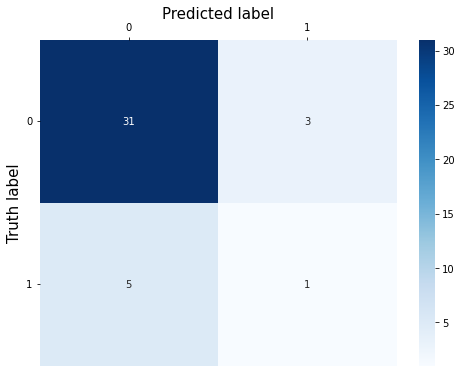

   accuracy  precision    recall  f1-score   tp-rate   fp-rate
0       0.8   0.861111  0.911765  0.885714  0.911765  0.833333
1       0.8   0.250000  0.166667  0.200000  0.166667  0.088235


In [715]:
# Classify test data
y_pred = []
for row_idx in range(len(folds[0]["x_test"])):
    row = folds[0]["x_test"].iloc[[row_idx]]
    sample = list(map(int,[row["rank"].values[0],\
        row["gre category"].values[0],\
            row["gpa category"].values[0]]))
    ans = classify_complete_sample(sample, admit_node)
    y_pred.append(ans[0])

cf_matrix = Metrics.get_confusion_matrix(folds[0]["y_test"].values.tolist(), y_pred, [0,1])
print("Accuracy: ", cf_matrix)
heat_map = Metrics.plot_confusion_matrix_heatmap(cf_matrix)

df = Metrics.get_metrics_per_class(cf_matrix)[1]
df.to_csv("./dump/metrics.csv")